# Deep learning methods in analysis of data in medicine : 

# APTOS Blindness Detection

In [1]:
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array, load_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import load_model
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import load_model

## Load data

In [2]:
train_data = pd.read_csv("/home/anna/kaggle/train.csv")

## Vizualization

    - histogram of frequency 
    - pie plot of frequency of classes in the individual subset - stratified split 
    - displey some images - sample


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


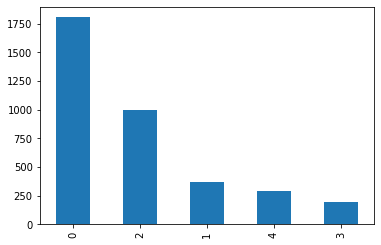

In [3]:
train_data.diagnosis.value_counts().plot(kind="bar")
train_data.head()

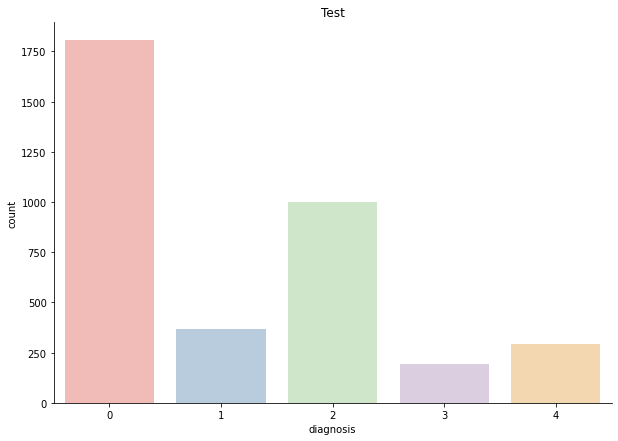

In [4]:
fig = plt.subplots(sharex='col', figsize=(10, 7))
sns.countplot(x="diagnosis", data=train_data, palette="Pastel1").set_title('Test')
sns.despine()
plt.show()

    - pie plot of frequency of classes in the individual subset - stratified split
    Stratified sampling aims at splitting a data set so that each split is similar with respect to something. In a classification setting, it is often chosen to ensure that the train and test sets have approximately the same percentage of samples of each target class as the complete set

<AxesSubplot:title={'center':'test data'}, ylabel='diagnosis'>

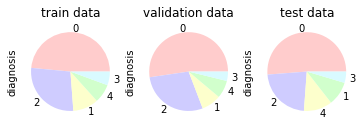

In [5]:
X_tt, X_ttest = train_test_split(train_data, test_size=0.1)
X_ttrain, X_vval = train_test_split(X_tt, test_size=0.15)

colors = ['#ffcccc','#cfccff','#fdffcc','#d1ffcc', '#d9faff']
fig, axes = plt.subplots(nrows=1, ncols=3)
X_ttrain.diagnosis.value_counts().plot(kind="pie", ax=axes[0],title="train data", colors= colors)
X_vval.diagnosis.value_counts().plot(kind="pie", ax=axes[1], title="validation data", colors= colors)
X_ttest.diagnosis.value_counts().plot(kind="pie", ax=axes[2], title="test data", colors= colors)

In [6]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

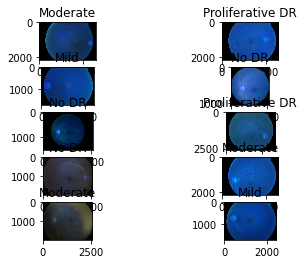

In [7]:
# Display some images
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("/home/anna/kaggle/train_data/",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

## Preprocessing dataset

    - image to araay
    - rescale

In [8]:
TRAIN_DATA_DIR = "/home/anna/kaggle/train_data/"
data =[]

def read_image_convert_to_array(filepath):
    image = load_img(TRAIN_DATA_DIR+filepath+".png", target_size=(224,224))
    image = img_to_array(image)k 
    image /= 255.0
    return image

train_data["img_data"] = train_data["id_code"].apply(lambda x: read_image_convert_to_array(x))

#### Split dataset 
       - train:test -> 8:2
       - train:valid -> 8.5:1.5
       - add target to categorical data (5 classes)
       

In [9]:
X = train_data["img_data"]
y = train_data["diagnosis"]
X = np.stack(X)
le = LabelEncoder()

y = le.fit_transform(y)

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)  
y_val = to_categorical(y_val)

In [10]:
num_classes = y_train.shape[1]

    - control shapes

In [11]:
print ("\nX_train:\n")
print (X_train.shape)

print ("\nX_test:\n ")
print (X_test.shape)

print ("\ny_train:\n")
print (y_train.shape)

print ("\ny_test:\n ")
print (y_test.shape)

print ("\ny_val:\n")
print (y_val.shape)

print ("\ny_val:\n ")
print (y_val.shape)

print ("\nnum_classes:\n ")
print (num_classes)


X_train:

(2800, 224, 224, 3)

X_test:
 
(367, 224, 224, 3)

y_train:

(2800, 5)

y_test:
 
(367, 5)

y_val:

(495, 5)

y_val:
 
(495, 5)

num_classes:
 
5


## CNN MODEL

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=[224,224,3], activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Dropout(0.1))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))
    
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='Adam')

#### Model information

    - summary information of model
    - plot model

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

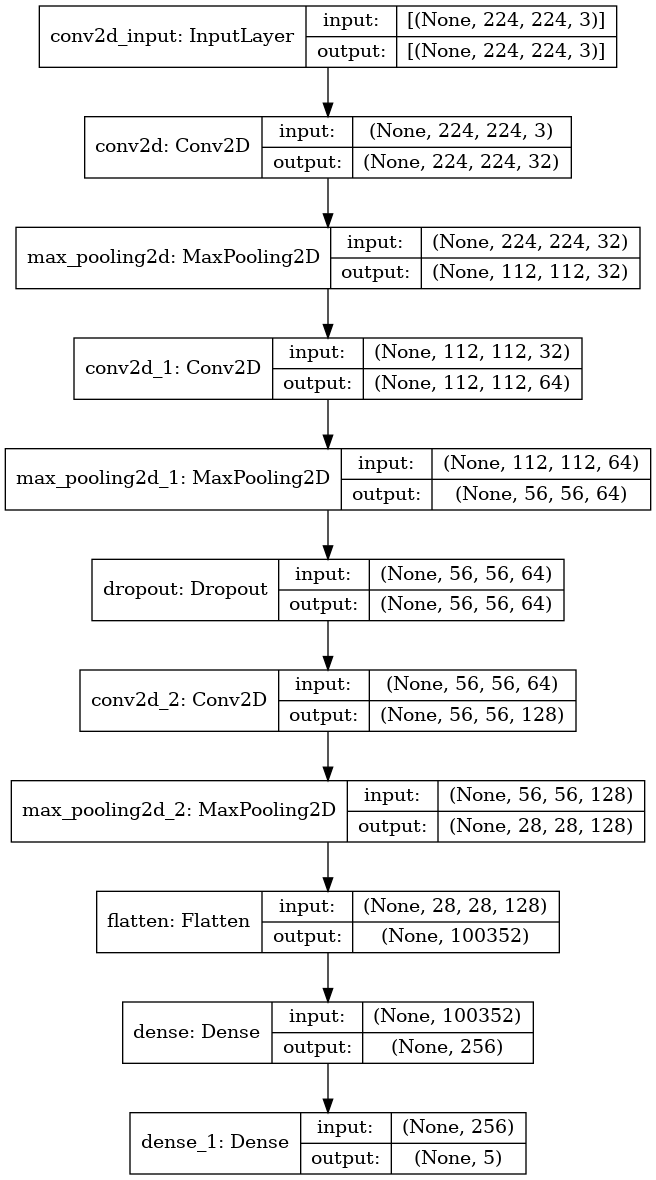

In [14]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)  # treba doinstalovat kniznice

## Training model

    - optimizer: Adam
    - loss: categorical crossentropy
    - epochs: 10 or 20
    - chcekpoint: minimum val_loss
    - batch size: 16

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

saved_model = "model_loss.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

epochs = 20
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = epochs, batch_size = 16, callbacks=[checkpoint])

Epoch 1/20
175/175 [==============================] - 206s 1s/step - loss: 1.2233 - acc: 0.6615 - val_loss: 0.8280 - val_acc: 0.6808

Epoch 00001: val_loss improved from inf to 0.82800, saving model to model_loss.hdf5
Epoch 2/20
175/175 [==============================] - 203s 1s/step - loss: 0.7314 - acc: 0.7273 - val_loss: 0.8070 - val_acc: 0.7071

Epoch 00002: val_loss improved from 0.82800 to 0.80698, saving model to model_loss.hdf5
Epoch 3/20
175/175 [==============================] - 205s 1s/step - loss: 0.7377 - acc: 0.7276 - val_loss: 0.7869 - val_acc: 0.7172

Epoch 00003: val_loss improved from 0.80698 to 0.78688, saving model to model_loss.hdf5
Epoch 4/20
175/175 [==============================] - 203s 1s/step - loss: 0.7287 - acc: 0.7291 - val_loss: 0.7985 - val_acc: 0.6970

Epoch 00004: val_loss did not improve from 0.78688
Epoch 5/20
175/175 [==============================] - 204s 1s/step - loss: 0.7075 - acc: 0.7426 - val_loss: 0.7734 - val_acc: 0.7010

Epoch 00005: val_lo

#### PLOT: training process
    - we use ModelCheckpoint -> saved model with the max validation accuracy 

In [16]:
def trainingProcess(history):
    plt.style.use('ggplot')
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

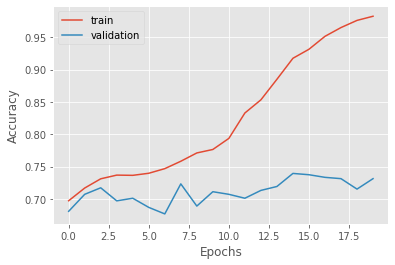

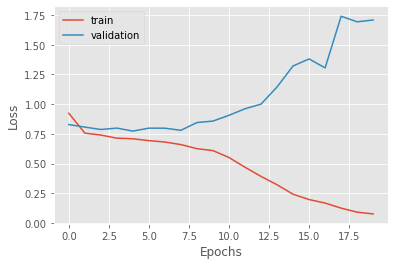

In [17]:
trainingProcess(history)

## Prediction 

    - load best model
    - predict test data
    - the results are probabilities -> threshold 0.5 -> results: metrix of integers

In [18]:
from keras.models import load_model

print("Loading model....")
model = load_model('model_loss.hdf5')

print("Predict....")
y_pred = model.predict(X_test)
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print("DONE")

Loading model....
Predict....
DONE


## Evalution
    - classification report (precission, recall, f1 score for all classes and their micro/macro average)
    - 2 types of confusion matrix 

In [19]:
print('Classification report {}'.format(classification_report(y_test, y_int, zero_division=0)))

Classification report               precision    recall  f1-score   support

           0       0.91      0.89      0.90       180
           1       0.00      0.00      0.00        40
           2       0.72      0.55      0.62       104
           3       0.33      0.06      0.10        17
           4       0.00      0.00      0.00        26

   micro avg       0.85      0.60      0.70       367
   macro avg       0.39      0.30      0.33       367
weighted avg       0.67      0.60      0.62       367
 samples avg       0.60      0.60      0.60       367



In [20]:
print('Confusion matrix {}'.format(multilabel_confusion_matrix(y_test, y_int)))

Confusion matrix [[[172  15]
  [ 19 161]]

 [[326   1]
  [ 40   0]]

 [[241  22]
  [ 47  57]]

 [[348   2]
  [ 16   1]]

 [[341   0]
  [ 26   0]]]


In [21]:
# borrowed from scikit learn
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[166   2  12   0   0]
 [  4   8  25   1   2]
 [  9  11  83   1   0]
 [  0   2  14   1   0]
 [  3   2  21   0   0]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

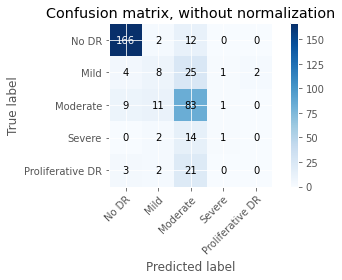

In [22]:
Y_pred_hot = np.argmax(y_pred,axis=1)
Y_actual_hot = np.argmax(y_test,axis=1)
plot_confusion_matrix(Y_actual_hot, Y_pred_hot, classes= np.array(class_labels))
